In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [115]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [116]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [117]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [118]:
Model_metrics = pd.DataFrame(columns=['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI', 'over max'])

# Base Model

In [119]:
model_base = FetchModel('base').compile()

In [120]:
data_base = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "y": Y_obs['Count_120'],
    "X": X_obs
}

fit_base = model_base.sample(data=data_base, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_base = az.from_cmdstanpy(fit_base)

21:34:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:36 - cmdstanpy - INFO - CmdStan done processing.


In [121]:
post_pred = PostPred(posterior_120_base, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

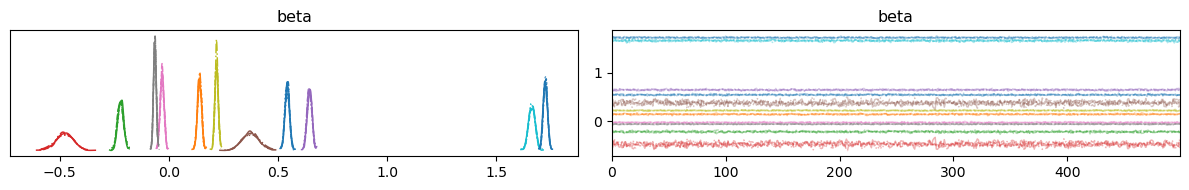

In [122]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [123]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13593.77   235.58
p_waic       42.35        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13593.92   235.59
p_loo       42.49        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [124]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [125]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   8   12   13   21   34   48   51   54   56   57   69   80   98  132
  133  141  145  154  157  165  166  169  173  211  212  213  219  227
  234  238  239  271  272  308  309  310  316  343  346  363  371  372
  378  380  383  384  385  391  394  403  404  407  410  413  414  420
  422  429  430  433  472  478  479  481  482  486  488  493  512  513
  519  525  558  581  585  595  598  599  600  605  608  609  613  634
  643  647  648  650  657  658  662  665  669  685  688  689  690  695
  705  708  709  720  739  747  752  753  757  758  760  767  769  770
  771  774  775  776  781  782  787  788  789  790  833  837  842  846
  863  864  874  876  877  878  901  908  911  917  924  925  926  927
  930  931  932  933  936  937  938  941  942  943  944  945  946  949
  957  958  959  960  963  964  968  969  971  972  976  977  978  979
  981  982  983  984  985  986  989  990  991  992  993  997  998  999
 1000 1006 1007 1011 1012 1016 1019 1021 1029 1039 1053 1059 1065 1

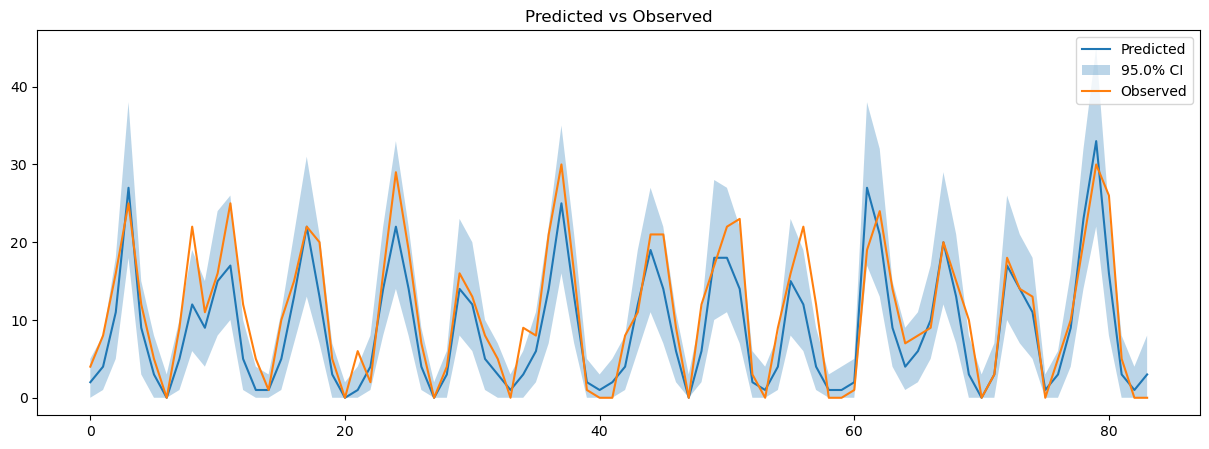

In [126]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [127]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

57


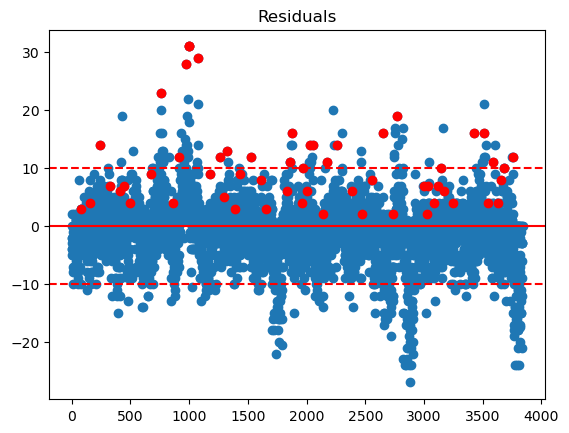

In [128]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

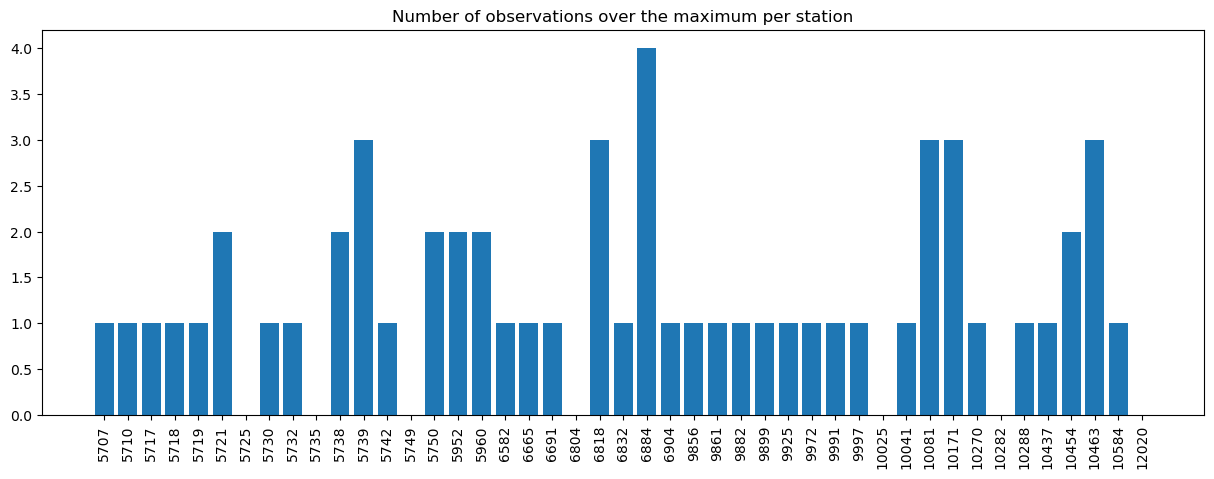

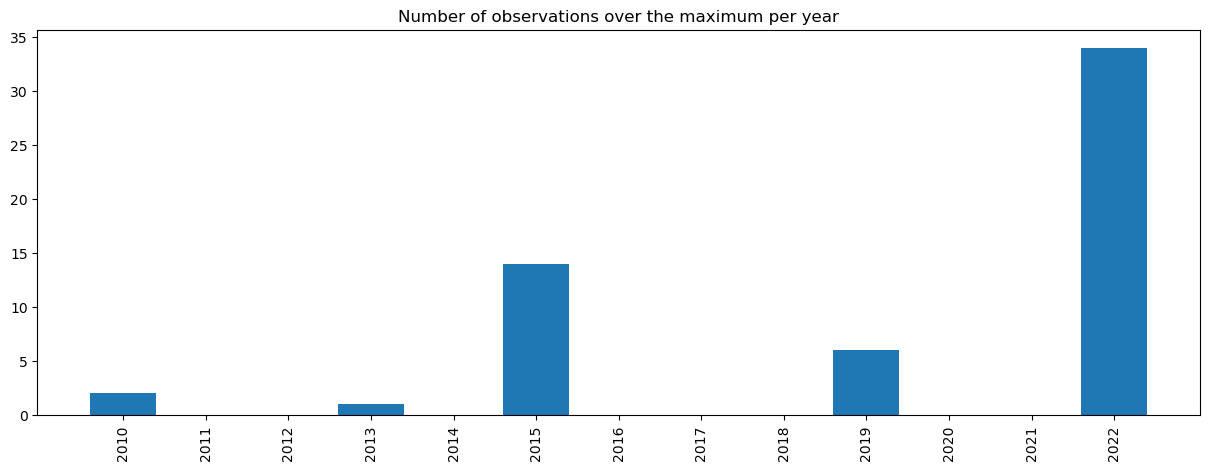

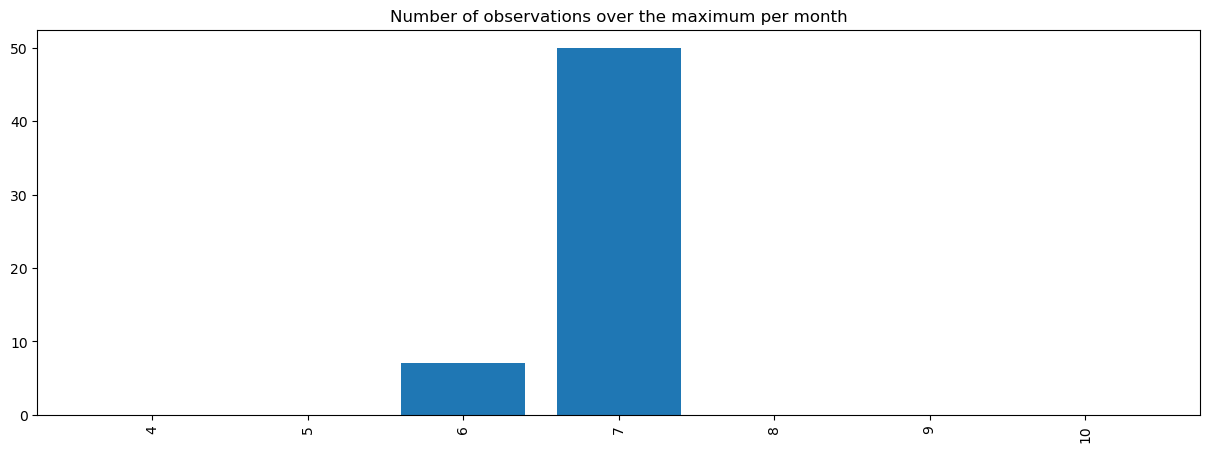

In [129]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [130]:
Model_metrics.loc['Base',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

             WAIC           LOO        MSE       MAE  MAD inside CI over max
Base -13593.77135 -13593.916491  29.691602  3.767057  3.0  0.802083       57


# Year model
We add the factor accounting for different years.

In [131]:
model_years = FetchModel('years').compile()

In [132]:
data_years = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs
}

fit_years = model_years.sample(data=data_years, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_years = az.from_cmdstanpy(fit_years)

21:34:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:21 - cmdstanpy - INFO - CmdStan done processing.


In [133]:
post_pred = PostPred(posterior_120_years, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

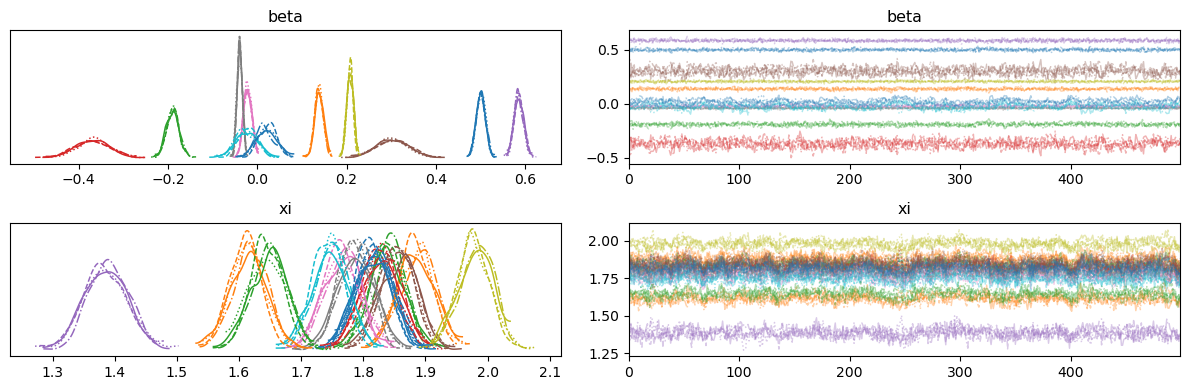

In [134]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi'])
plt.tight_layout()
plt.show()

In [135]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11140.40   115.09
p_waic       55.79        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11140.55   115.10
p_loo       55.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [136]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [137]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   8   13   21   34   51   57   69   80   83   99  145  154  165  179
  227  234  264  308  309  310  346  350  363  371  384  385  391  394
  403  404  407  410  414  420  422  429  430  472  478  481  482  486
  488  493  505  512  514  519  525  544  545  550  581  585  595  599
  600  605  608  609  613  618  634  640  643  647  648  650  657  658
  662  665  669  675  688  689  690  695  699  705  708  739  747  753
  757  758  760  767  768  769  770  771  774  775  776  781  782  787
  789  792  808  842  846  861  862  863  864  869  874  876  877  901
  908  911  924  925  926  927  930  931  932  933  935  936  937  938
  942  943  945  949  956  957  958  959  960  963  964  968  969  970
  971  972  976  977  978  979  981  982  983  984  985  986  989  990
  991  992  993  997  998  999 1000 1006 1007 1011 1012 1015 1017 1020
 1021 1039 1049 1053 1059 1064 1065 1066 1070 1073 1078 1079 1081 1101
 1105 1113 1129 1130 1133 1136 1144 1146 1153 1158 1165 1167 1168 1

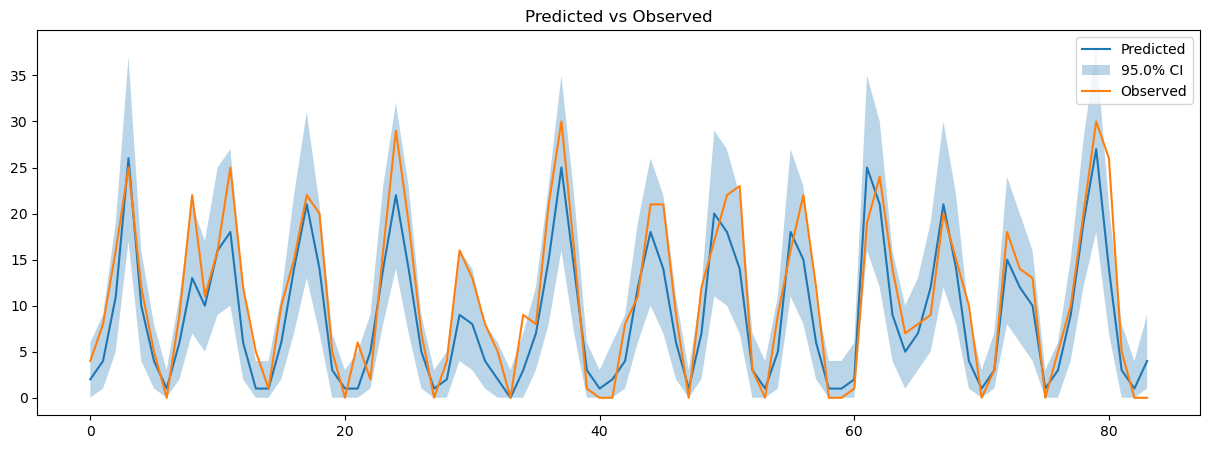

In [138]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [139]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

22


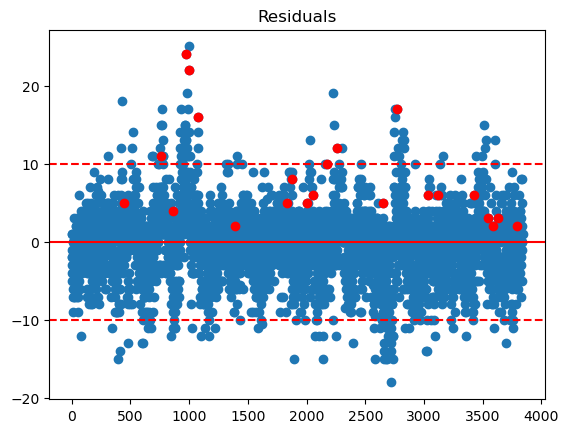

In [140]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

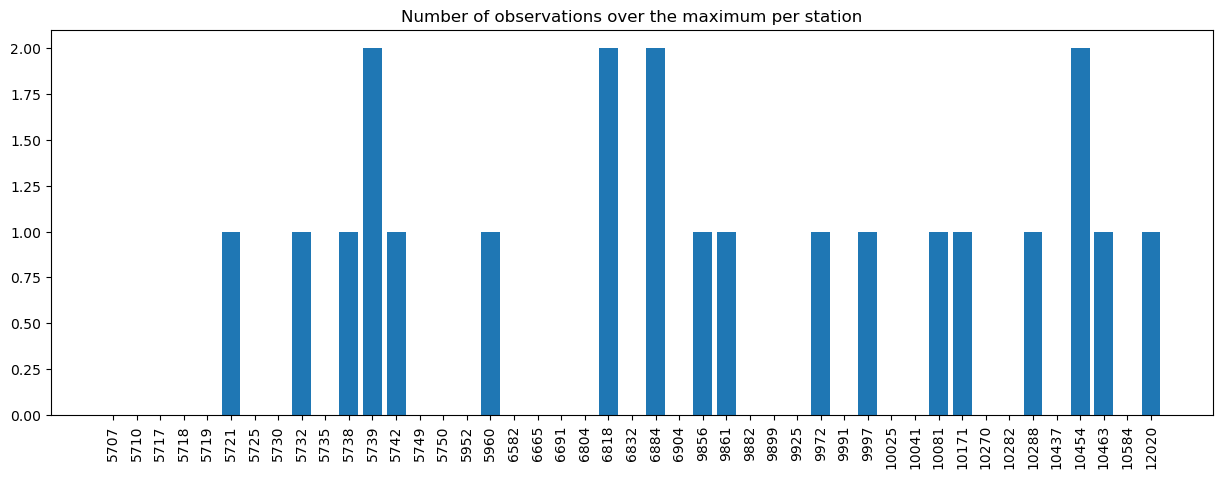

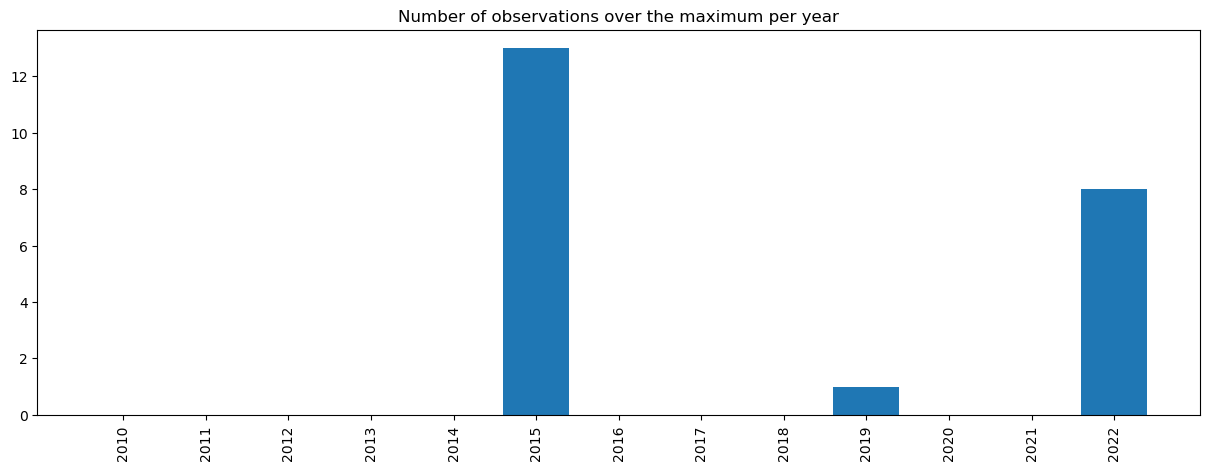

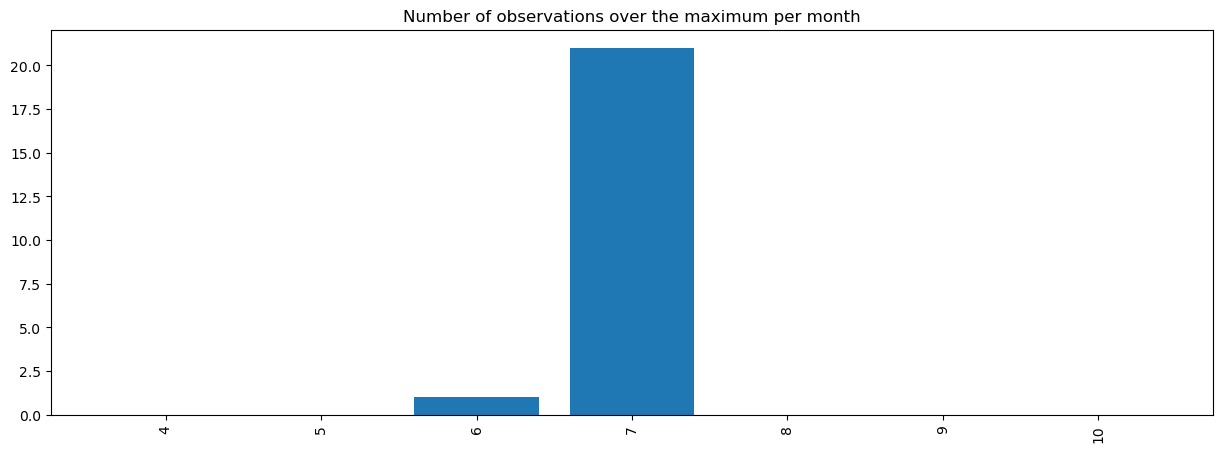

In [141]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [142]:
Model_metrics.loc['Years',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

               WAIC           LOO        MSE       MAE  MAD inside CI over max
Base   -13593.77135 -13593.916491  29.691602  3.767057  3.0  0.802083       57
Years -11140.401302 -11140.553953  19.549414  3.252474  2.0  0.861719       22


# Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [143]:
model_stations = FetchModel('stations').compile()

In [144]:
data_stations = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs
}


fit_stations = model_stations.sample(data=data_stations, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_stations = az.from_cmdstanpy(fit_stations)

21:35:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:39 - cmdstanpy - INFO - CmdStan done processing.


21:39:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 132 iterations at max treedepth (26.4%)
	Chain 2 had 149 iterations at max treedepth (29.8%)
	Chain 3 had 102 iterations at max treedepth (20.4%)
	Chain 4 had 131 iterations at max treedepth (26.2%)
	Use function "diagnose()" to see further information.


In [145]:
post_pred = PostPred(posterior_120_stations, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

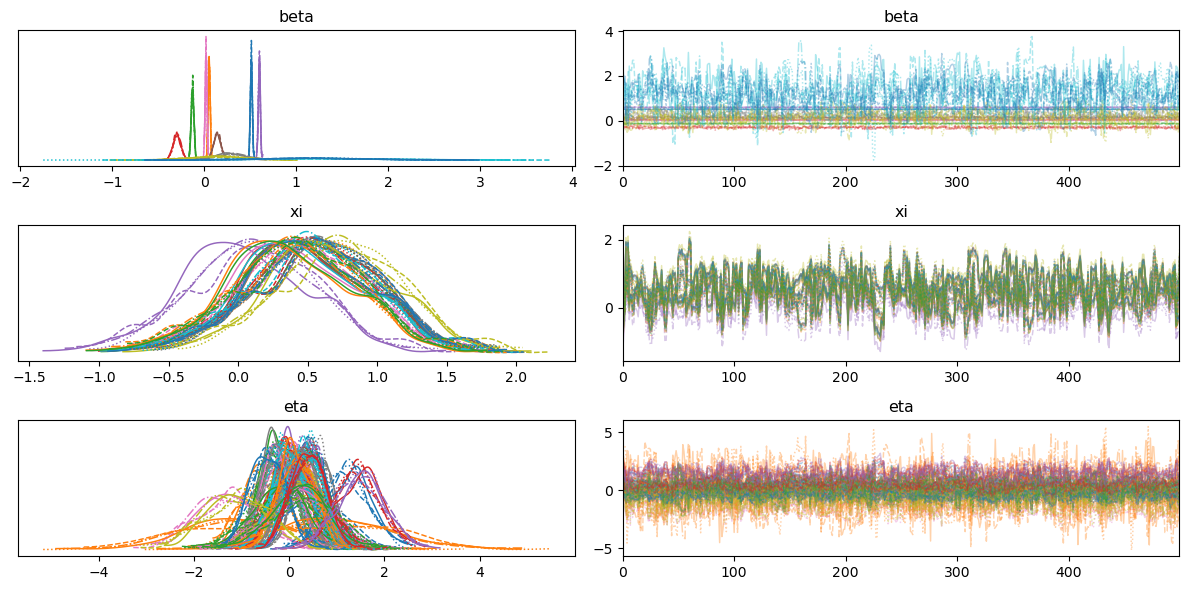

In [146]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta'])
plt.tight_layout()
plt.show()

In [147]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10099.63    86.20
p_waic      104.32        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10099.91    86.20
p_loo      104.60        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [148]:
eta = post_pred.posterior.eta
eta
len(np.unique(stations))

45

In [149]:
lam = post_pred.posterior['lambda']

In [150]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [151]:
inference_lam = []
for i in range(len(Y_obs['Count_120'])):
    ar1 = lam[0, :, i]-Y_obs['Count_120'][i]
    ar2 = lam[1, :, i]-Y_obs['Count_120'][i]
    ar3 = lam[2, :, i]-Y_obs['Count_120'][i]
    ar4 = lam[3, :, i]-Y_obs['Count_120'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)

In [152]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original[idx_obs])
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [153]:
df = pd.DataFrame(inference_lam).transpose()
df.shape
df.columns.values

array([   0,    1,    2, ..., 3837, 3838, 3839], dtype=int64)

In [154]:
import os
if not os.path.exists('../Datasets/Space_estimate'):
    os.makedirs('../Datasets/Space_estimate')

csv_path = '../Datasets/Space_estimate/eta_120.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

csv_path = '../Datasets/Space_estimate/res_120.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

In [155]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [156]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  179  227  234  286  309  350  362  363  385
  391  394  396  404  410  413  414  420  422  429  433  472  478  479
  481  482  486  488  493  512  513  519  581  582  585  588  599  609
  634  648  650  662  665  669  680  682  685  690  695  701  718  753
  757  769  770  771  774  775  781  787  799  802  807  824  835  842
  863  864  869  874  876  877  884  898  901  917  919  920  921  931
  950  955  962  970  984 1012 1016 1019 1021 1022 1026 1032 1042 1049
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1248 1255
 1283 1329 1331 1341 1371 1384 1385 1407 1408 1449 1457 1527 1535 1540
 1552 1563 1591 1611 1631 1639 1765 1774 1786 1824 1848 1859 1867 1869
 1874 1880 1889 1897 1903 1911 1912 1923 1953 1955 1960 1978 1983 1989
 2008 2026 2029 2050 2075 2076 2089 2115 2119 2127 2134 2137 2140 2144
 2180 2198 2221 2227 2228 2233 2234 2238 2241 2250 2251 2274 2291 2301
 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406 2430 2458 2460 2

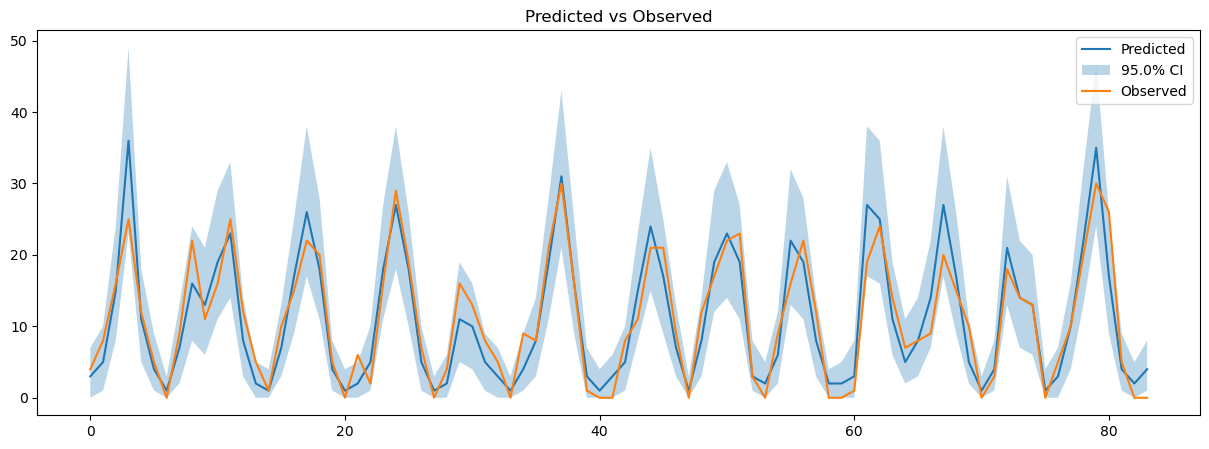

In [157]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [158]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

48


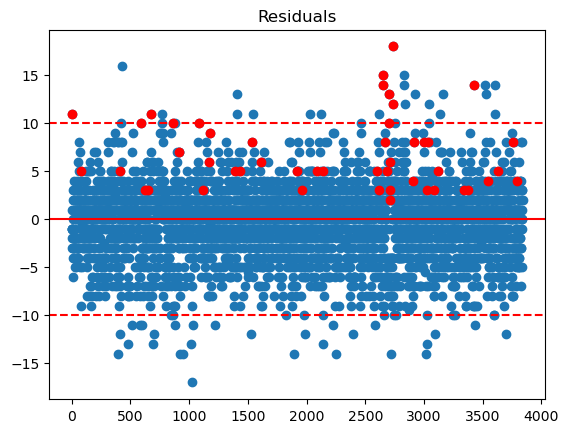

In [159]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

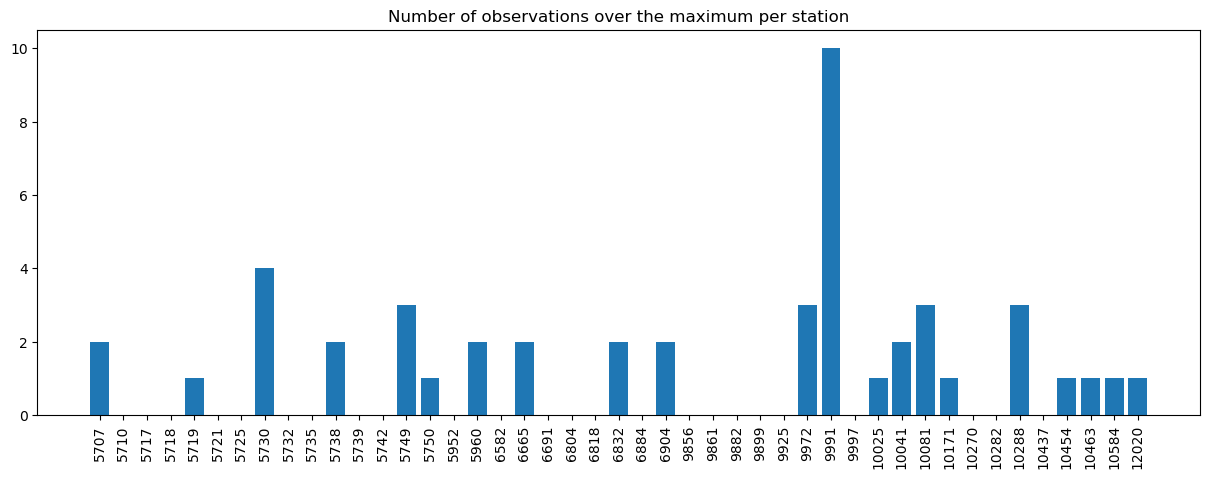

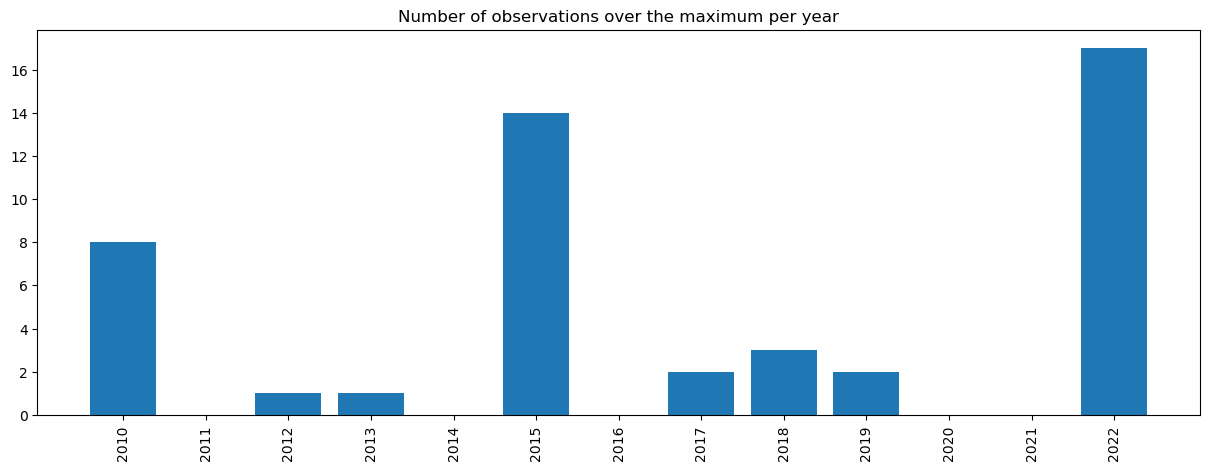

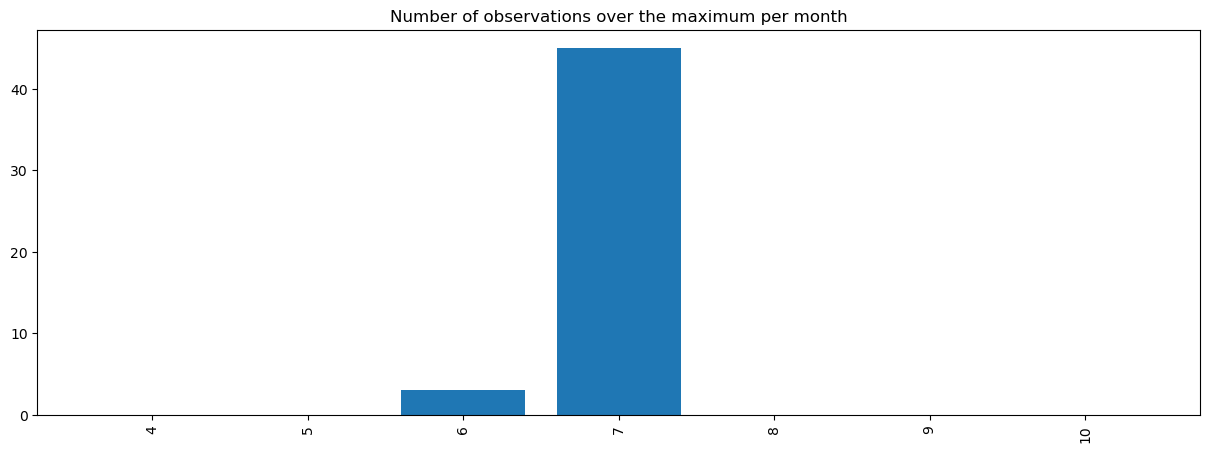

In [160]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [161]:
Model_metrics.loc['Stations',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                  WAIC           LOO        MSE       MAE  MAD inside CI  \
Base      -13593.77135 -13593.916491  29.691602  3.767057  3.0  0.802083   
Years    -11140.401302 -11140.553953  19.549414  3.252474  2.0  0.861719   
Stations -10099.627245   -10099.9142  14.017318  2.792969  2.0   0.91224   

         over max  
Base           57  
Years          22  
Stations       48  


# Space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [162]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [163]:
model_space = FetchModel('space').compile()

In [164]:
data_space = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data_space, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_space = az.from_cmdstanpy(fit_space)

21:40:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:51 - cmdstanpy - INFO - CmdStan done processing.
21:42:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = 

In [165]:
post_pred = PostPred(posterior_120_space, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

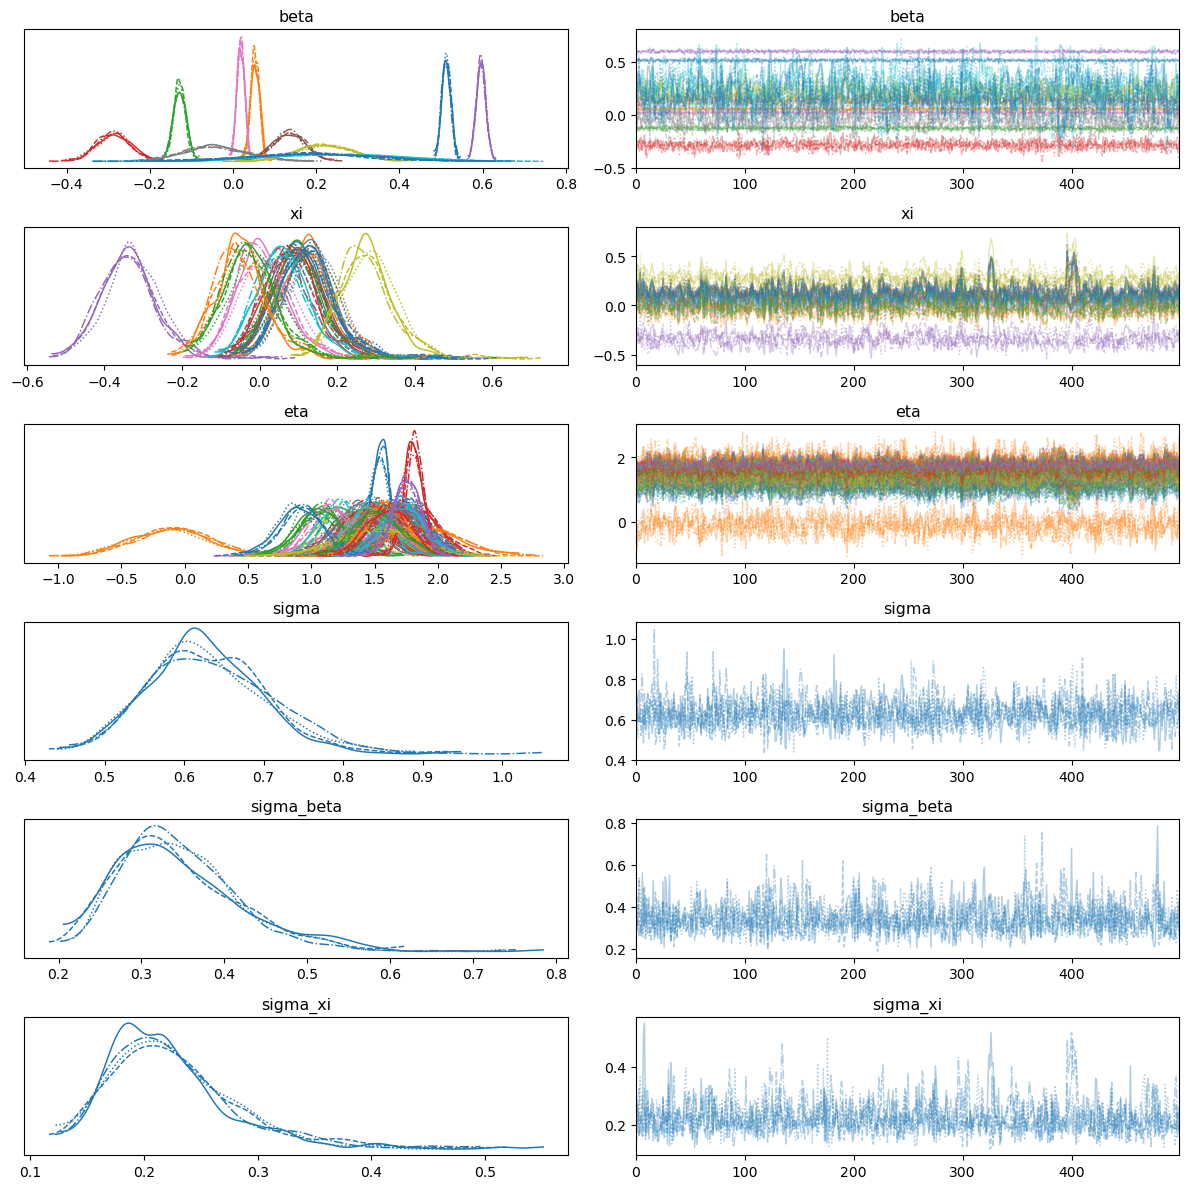

In [166]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [167]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.10    86.09
p_waic      101.23        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10100.44    86.10
p_loo      101.56        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [168]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [169]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  227  234  309  350  363  385  391  394  396
  404  410  413  414  420  422  429  430  433  472  478  479  481  482
  486  488  493  512  513  519  551  558  581  582  585  588  599  609
  618  634  643  648  650  662  665  669  680  682  685  690  695  701
  718  753  757  769  770  771  774  775  781  787  799  802  807  824
  835  842  863  864  869  874  876  877  884  901  917  919  920  921
  931  950  955  962  970  984 1012 1016 1019 1021 1022 1026 1032 1042
 1049 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1255
 1283 1329 1331 1341 1371 1384 1385 1407 1408 1409 1449 1457 1527 1535
 1540 1552 1563 1591 1611 1631 1639 1765 1774 1786 1802 1824 1859 1867
 1869 1874 1880 1889 1897 1903 1911 1912 1923 1953 1955 1960 1978 1983
 1989 2026 2029 2050 2075 2076 2089 2115 2119 2127 2134 2137 2140 2144
 2149 2160 2180 2198 2221 2227 2228 2234 2238 2241 2251 2274 2291 2301
 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406 2412 2430 2458 2

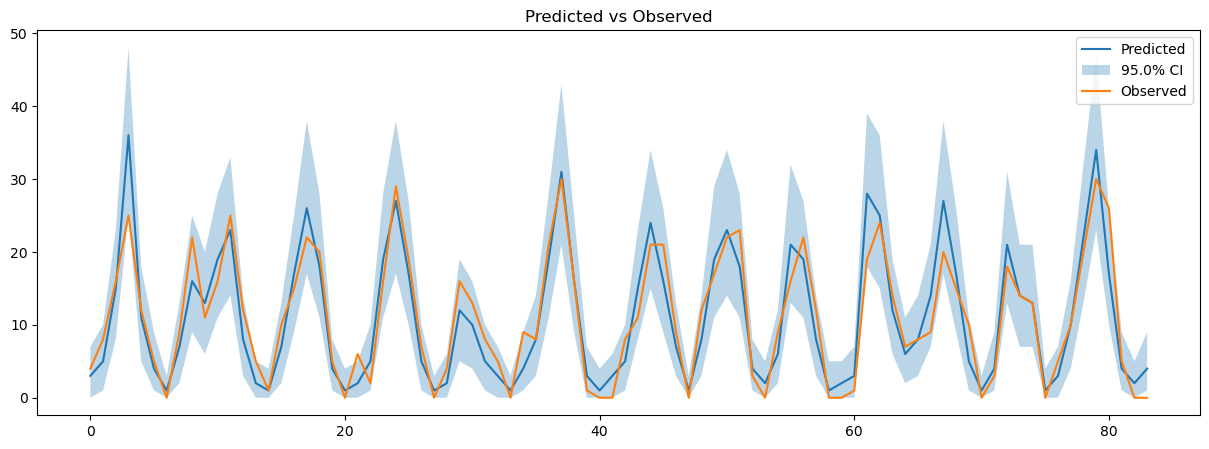

In [170]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [171]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

48


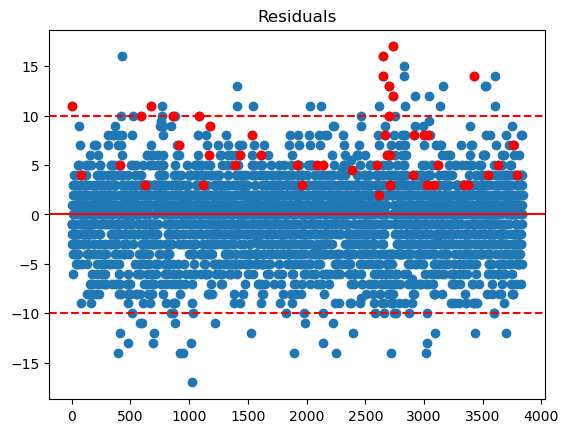

In [172]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

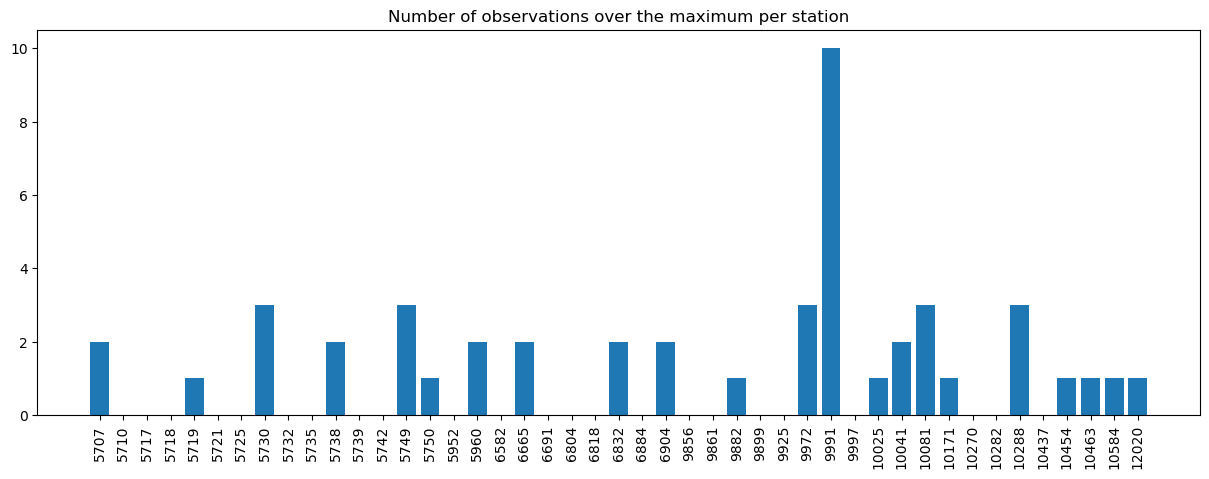

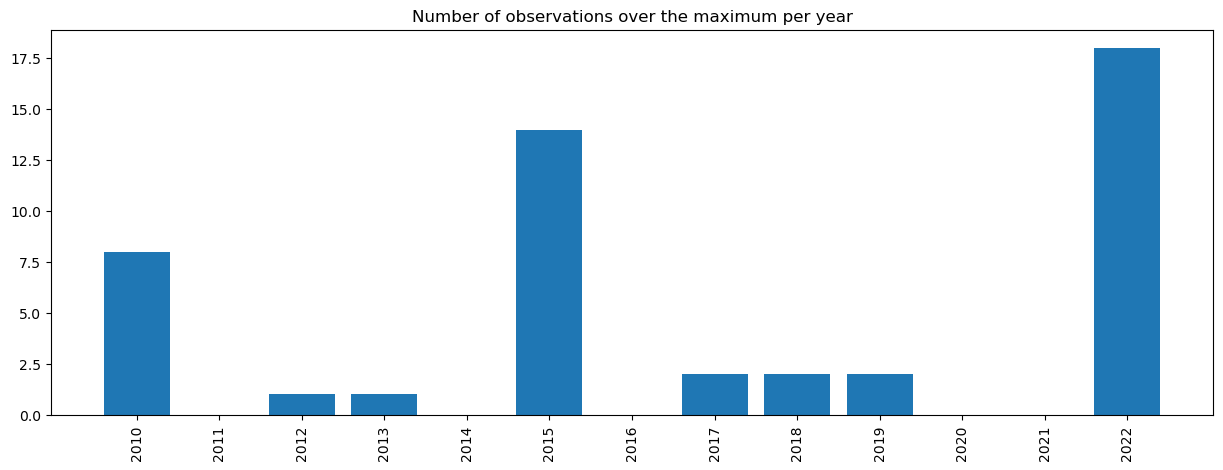

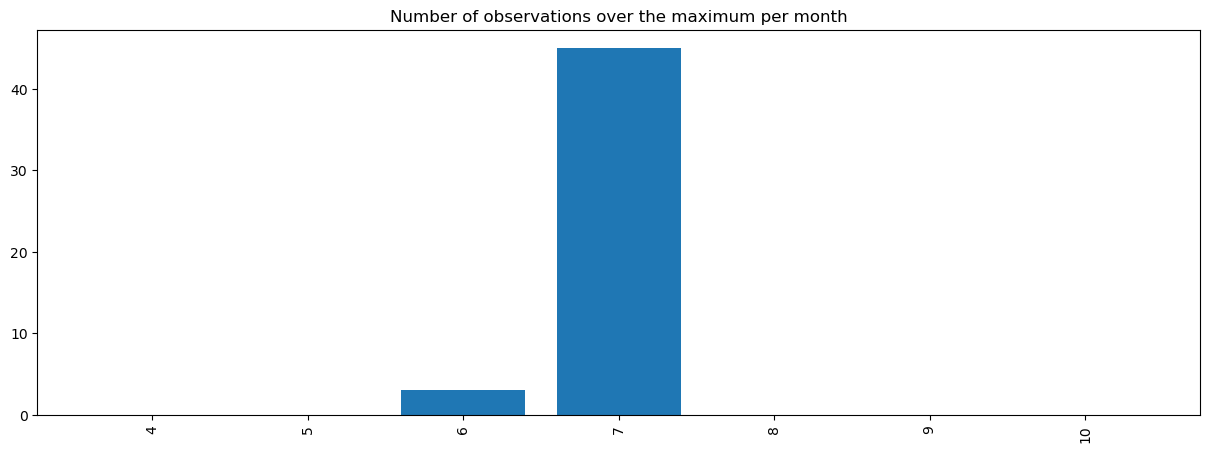

In [173]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [174]:
Model_metrics.loc['Spatial',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                  WAIC           LOO        MSE       MAE  MAD inside CI  \
Base      -13593.77135 -13593.916491  29.691602  3.767057  3.0  0.802083   
Years    -11140.401302 -11140.553953  19.549414  3.252474  2.0  0.861719   
Stations -10099.627245   -10099.9142  14.017318  2.792969  2.0   0.91224   
Spatial  -10100.102058 -10100.439242  13.997201  2.794141  2.0  0.911458   

         over max  
Base           57  
Years          22  
Stations       48  
Spatial        48  


In [175]:
model_space_bis = FetchModel('space_bis').compile()

In [176]:
data_space_bis = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}


fit_space_bis = model_space_bis.sample(data=data_space_bis, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_space_bis = az.from_cmdstanpy(fit_space_bis)

21:43:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:40 - cmdstanpy - INFO - CmdStan done processing.
21:46:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symm

In [177]:
post_pred = PostPred(posterior_120_space_bis, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

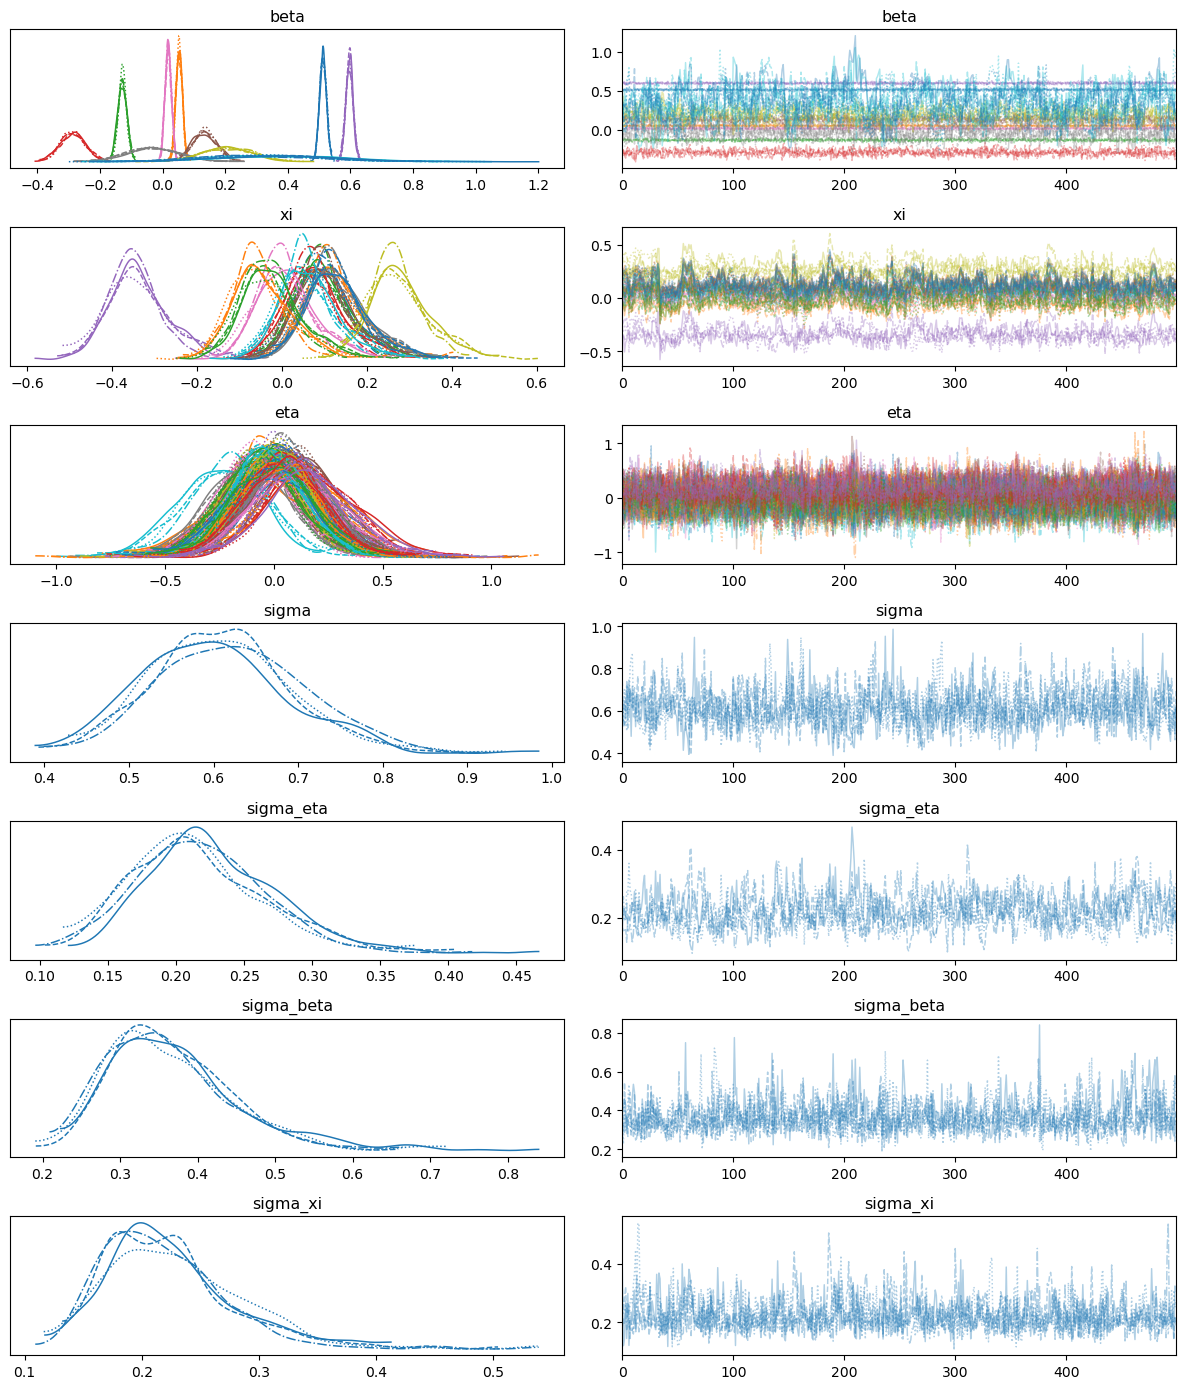

In [178]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [179]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.64    86.11
p_waic      102.19        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10101.04    86.13
p_loo      102.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [180]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [181]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   34   80   83   99  145  154  165  173  227  234  309  350  362
  363  385  391  394  396  404  410  413  414  420  422  429  430  433
  472  478  479  481  482  486  488  493  512  513  519  551  581  582
  585  588  599  609  643  648  650  662  665  669  680  682  685  690
  695  701  718  753  757  769  770  771  774  775  781  787  799  802
  807  824  835  842  863  864  869  874  876  877  884  898  901  917
  919  920  921  931  950  955  962  970  984 1012 1016 1019 1021 1022
 1026 1032 1042 1049 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185
 1195 1222 1248 1283 1329 1331 1341 1371 1384 1385 1407 1408 1449 1457
 1527 1535 1540 1552 1563 1591 1611 1631 1639 1667 1765 1774 1786 1824
 1848 1859 1867 1869 1874 1880 1889 1897 1903 1911 1912 1923 1953 1955
 1960 1978 1983 1989 2026 2029 2050 2075 2076 2089 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2228 2234 2238 2241 2250 2251 2274
 2291 2301 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406 2430 2

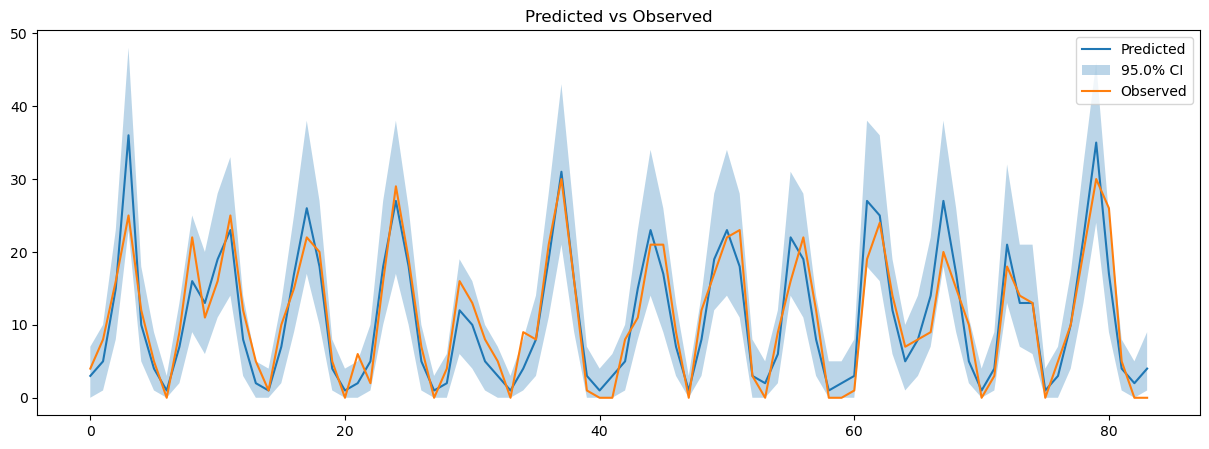

In [182]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

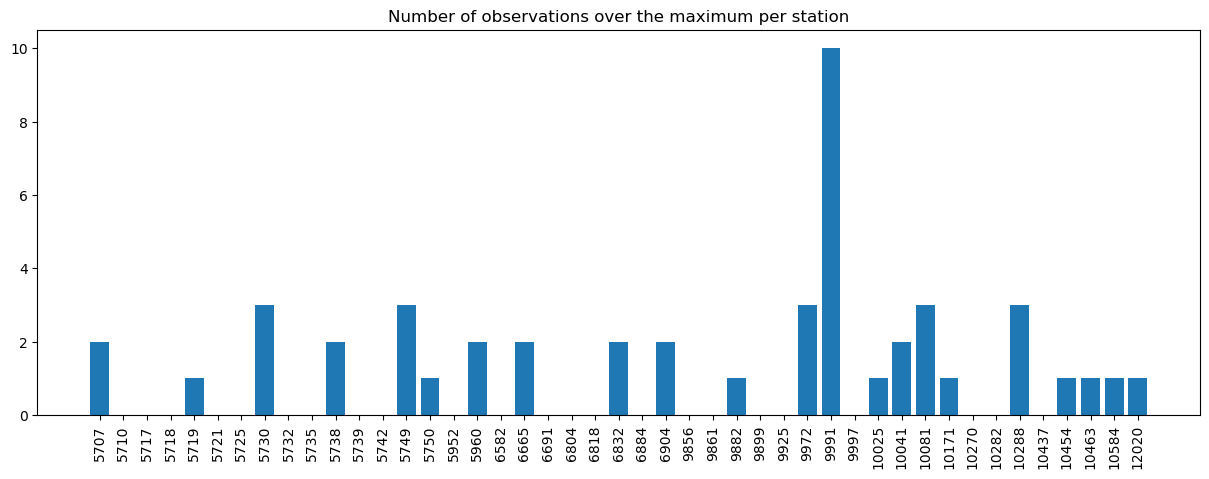

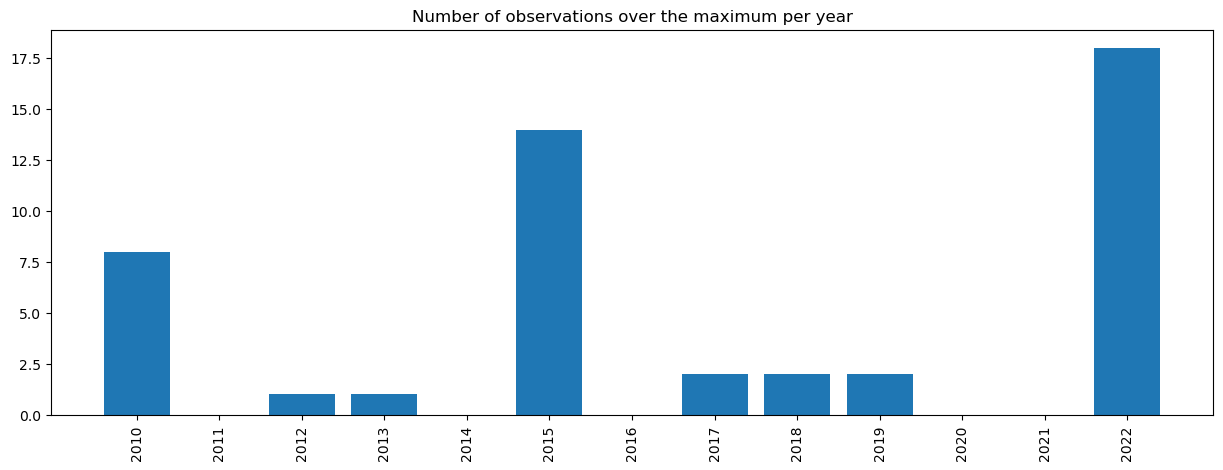

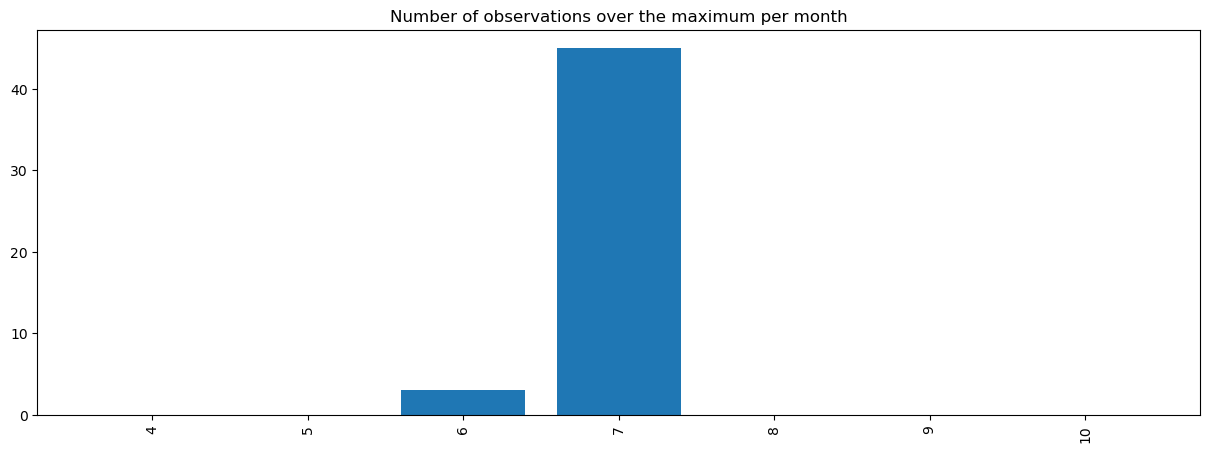

In [183]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [184]:
Model_metrics.loc['Spatial 2',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                   WAIC           LOO        MSE       MAE  MAD inside CI  \
Base       -13593.77135 -13593.916491  29.691602  3.767057  3.0  0.802083   
Years     -11140.401302 -11140.553953  19.549414  3.252474  2.0  0.861719   
Stations  -10099.627245   -10099.9142  14.017318  2.792969  2.0   0.91224   
Spatial   -10100.102058 -10100.439242  13.997201  2.794141  2.0  0.911458   
Spatial 2 -10100.638952 -10101.035487  14.024349  2.798958  2.0  0.911458   

          over max  
Base            57  
Years           22  
Stations        48  
Spatial         48  
Spatial 2       48  


# Speace Model with a dummy variable  

In [185]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [187]:
model_space_dummy = FetchModel('space_dummy').compile()

21:58:47 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy.exe
21:59:41 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_dummy.exe


In [188]:
data_space_july = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs
}

fit_space_july = model_space_dummy.sample(data=data_space_july, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_july = az.from_cmdstanpy(fit_space_july)

21:59:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:04:39 - cmdstanpy - INFO - CmdStan done processing.
22:04:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy.stan', line 42, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy.stan', line 42, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy.stan', line 42, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy.stan', line 42, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive

In [189]:
post_pred = PostPred(posterior_120_july, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

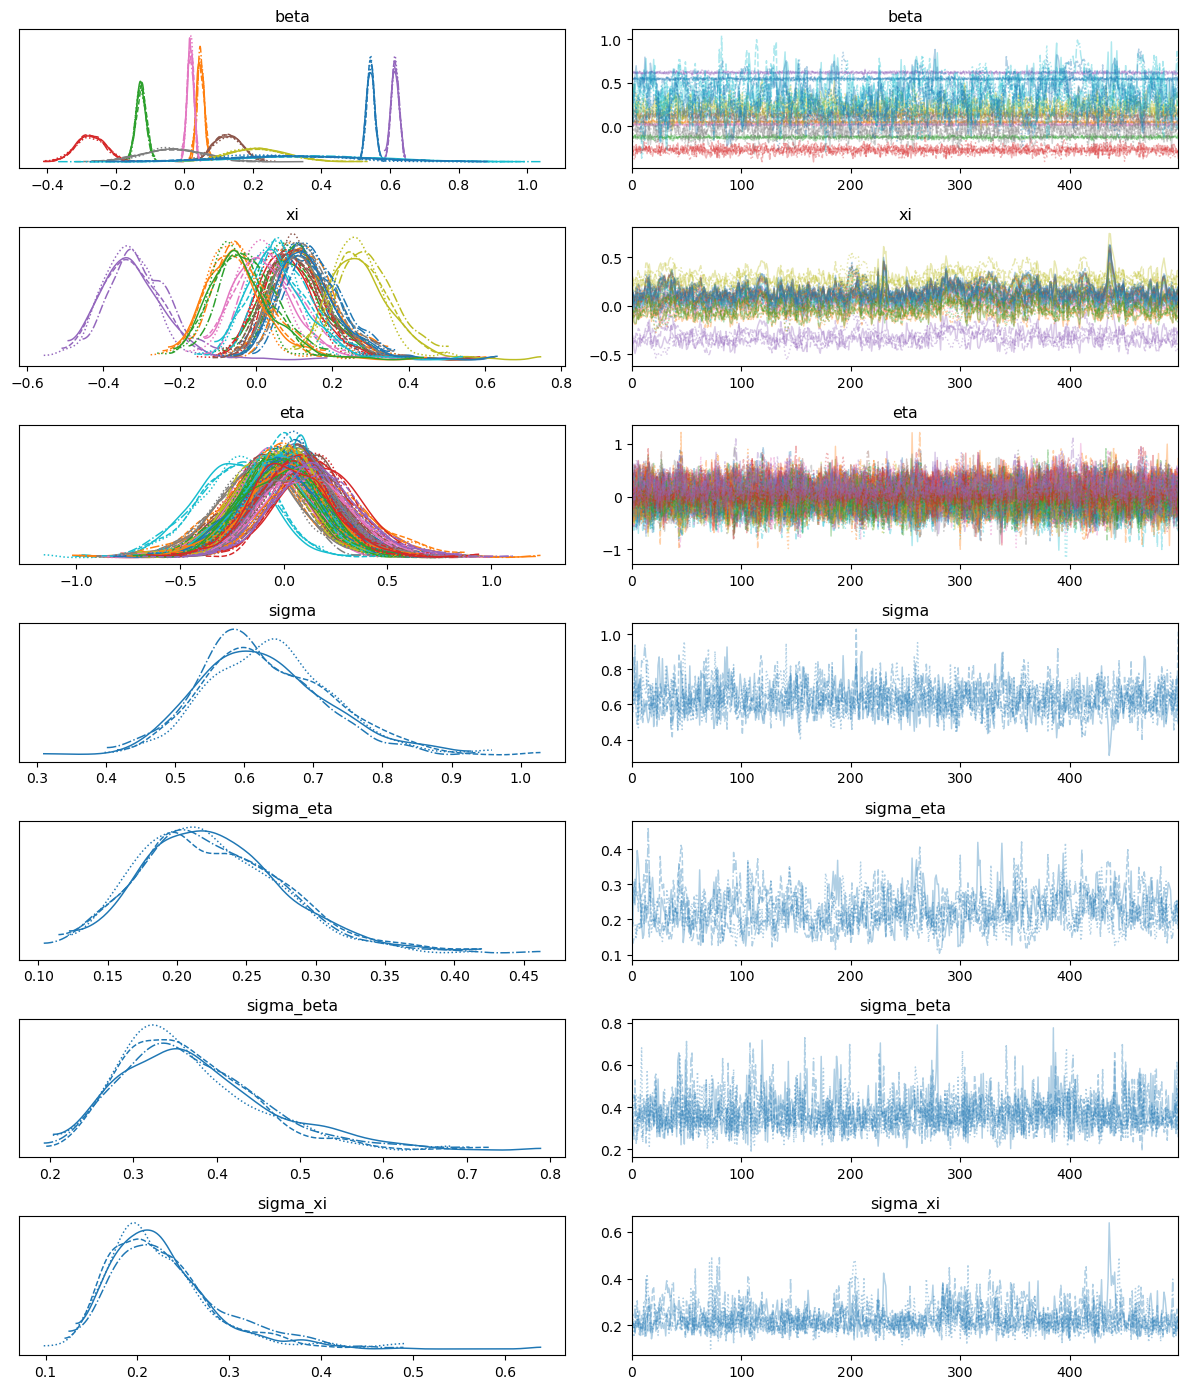

In [190]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [191]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10059.15    86.76
p_waic      155.44        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10059.92    86.77
p_loo      156.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3837   99.9%
 (0.5, 0.7]   (ok)          3    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [192]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [193]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  173  227  234  309  350  351  362  363  385
  391  394  396  404  410  413  414  420  422  429  430  433  472  477
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  634  643  648  650  662  665  669  680  682  685  689
  690  695  701  718  753  757  769  770  771  774  775  781  799  802
  807  824  835  842  863  864  869  874  876  877  884  898  917  918
  919  920  921  931  950  955  962  984 1009 1016 1019 1021 1022 1026
 1042 1043 1053 1073 1105 1118 1146 1158 1165 1179 1185 1195 1222 1255
 1283 1329 1331 1341 1371 1384 1385 1407 1408 1449 1457 1527 1535 1540
 1552 1553 1563 1611 1631 1639 1667 1692 1774 1786 1824 1848 1859 1867
 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978 1983 1989
 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134 2137 2140 2144
 2180 2198 2221 2227 2228 2234 2238 2241 2250 2251 2274 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2

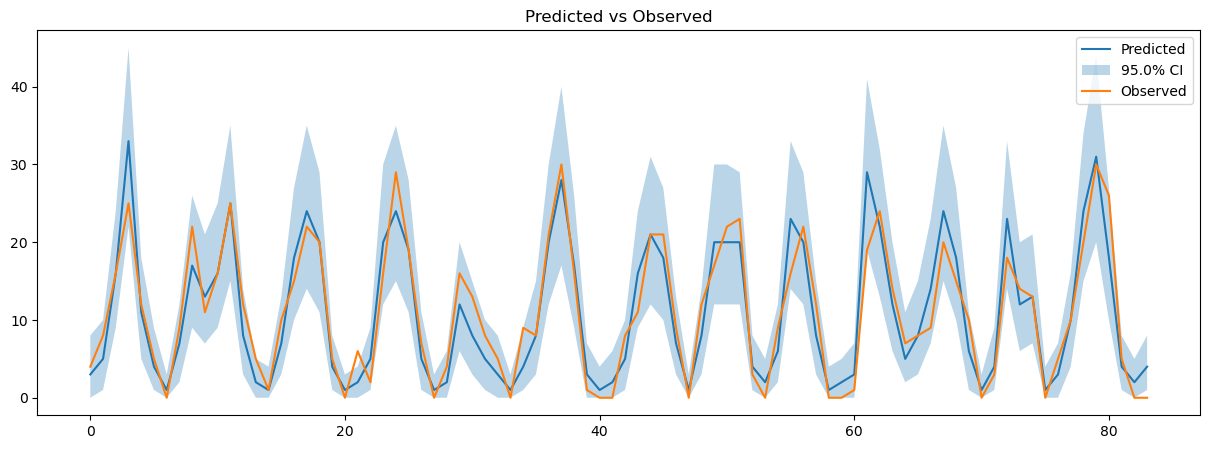

In [194]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [195]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

21


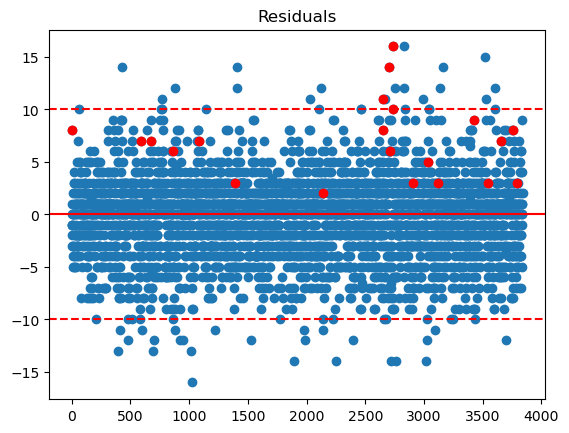

In [196]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

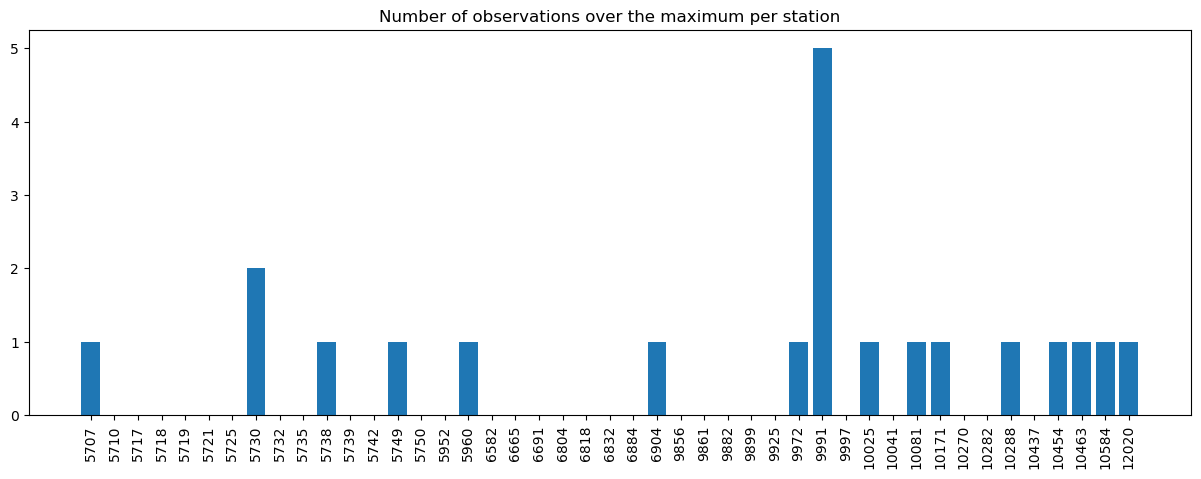

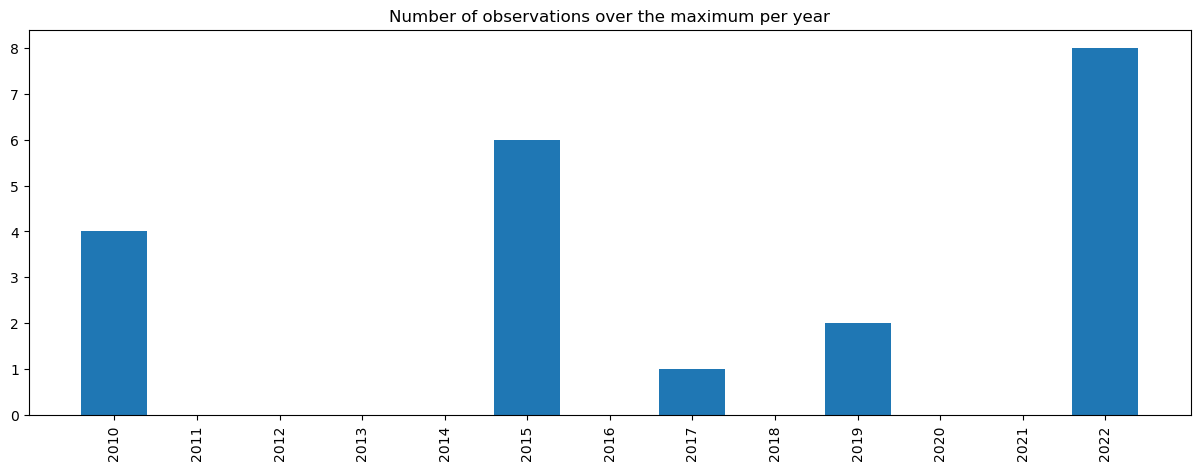

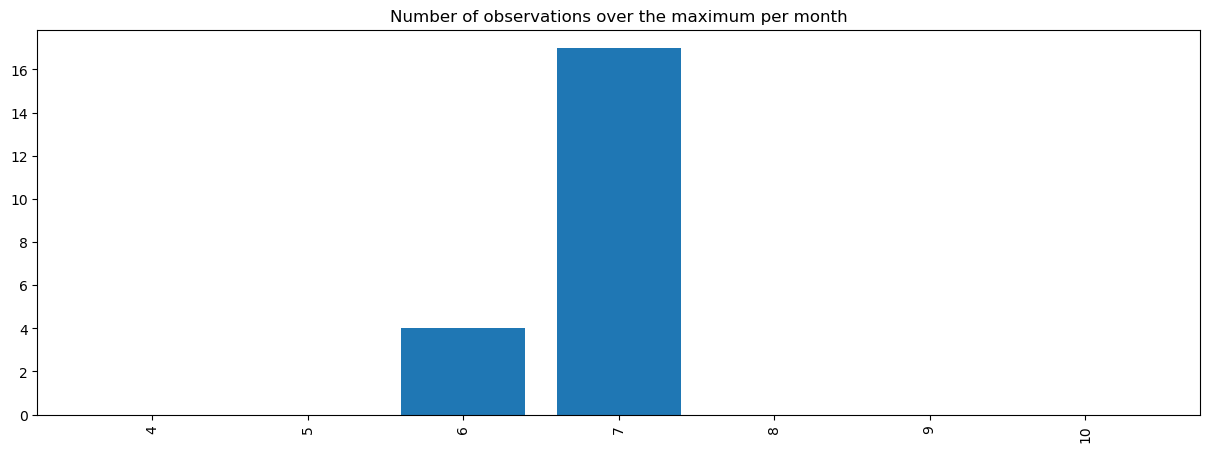

In [197]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [198]:
Model_metrics.loc['Spatial 2 Dummy',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                         WAIC           LOO        MSE       MAE  MAD  \
Base             -13593.77135 -13593.916491  29.691602  3.767057  3.0   
Years           -11140.401302 -11140.553953  19.549414  3.252474  2.0   
Stations        -10099.627245   -10099.9142  14.017318  2.792969  2.0   
Spatial         -10100.102058 -10100.439242  13.997201  2.794141  2.0   
Spatial 2       -10100.638952 -10101.035487  14.024349  2.798958  2.0   
Spatial 2 Dummy -10059.149584 -10059.915617  13.509766  2.735937  2.0   

                inside CI over max  
Base             0.802083       57  
Years            0.861719       22  
Stations          0.91224       48  
Spatial          0.911458       48  
Spatial 2        0.911458       48  
Spatial 2 Dummy  0.913542       21  
